The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


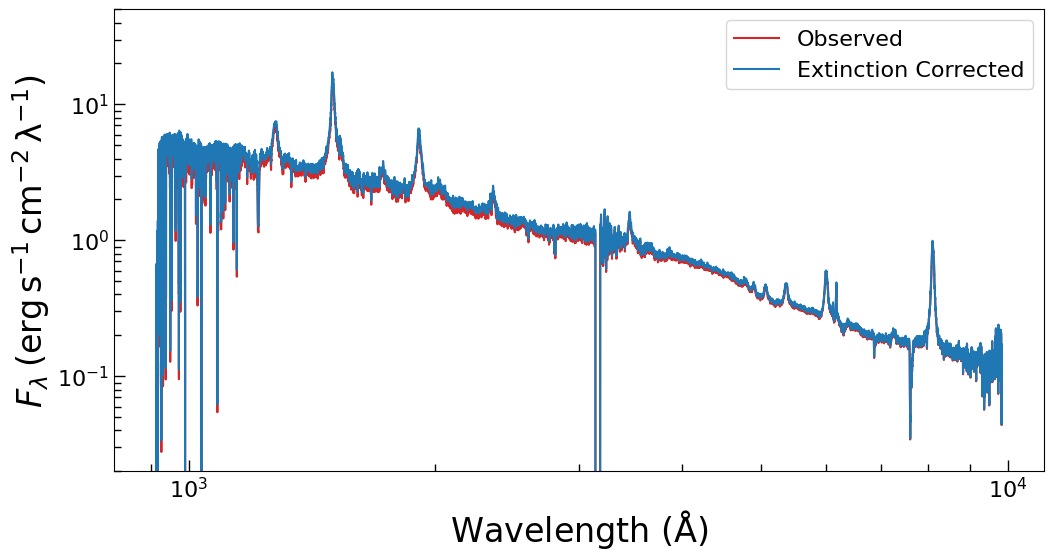

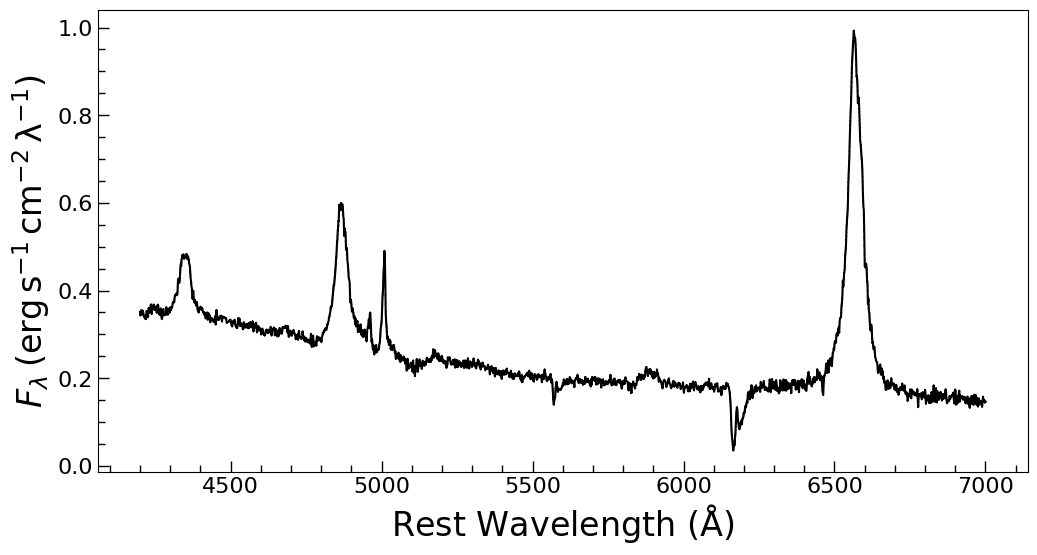

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from astropy.modeling import models, fitting
import sys
sys.path.append("../..")
import sagan

import matplotlib as mpl
mpl.rc("xtick", direction="in", labelsize=16)
mpl.rc("ytick", direction="in", labelsize=16)
mpl.rc("xtick.major", width=1., size=8)
mpl.rc("ytick.major", width=1., size=8)
mpl.rc("xtick.minor", width=1., size=5)
mpl.rc("ytick.minor", width=1., size=5)

# automatic reload the modules
%load_ext autoreload
%autoreload 2

ls_km = 2.99792e5 # km/s
datapath = 'data'
hdul = fits.open('pg0953sed.fit')#---------------------------修改文件名
header = hdul[0].header
flux = hdul[0].data * 1e14

w0 = header['CRVAL1']
dw = header['CD1_1']
wave = w0 + dw*np.arange(flux.size)

# Find the V band attenuation from https://ned.ipac.caltech.edu/ -- FOREGROUND GALACTIC EXTINCTION
from extinction import ccm89, remove

A_V = 0.033    #------------------------------修改 消光系数
flux_dred = remove(ccm89(wave, A_V, r_v=3.1, unit='aa'), flux)

fig, ax = plt.subplots(figsize=(12, 6))
ax.step(wave, flux, label='Observed', c='C3')
ax.step(wave, flux_dred, label='Extinction Corrected', c='C0')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.legend(fontsize=16)
ax.set_ylim(0.02, 50)#-------------------------------修改y可见范围
ax.minorticks_on()
plt.show()
zred = 0.2338 #-------------------------------------修改红移

fig, ax = plt.subplots(figsize=(12, 6))
wmin, wmax = 4200, 7000
wave_rst = wave / (1 + zred)
fltr = (wave_rst > wmin) & (wave_rst < wmax)
wave_use = wave_rst[fltr]
flux_use = flux_dred[fltr]

ax.step(wave_use, flux_use, color='k')
ax.set_xlabel(r'Rest Wavelength ($\mathrm{\AA}$)', fontsize=24)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
ax.minorticks_on()
plt.show()

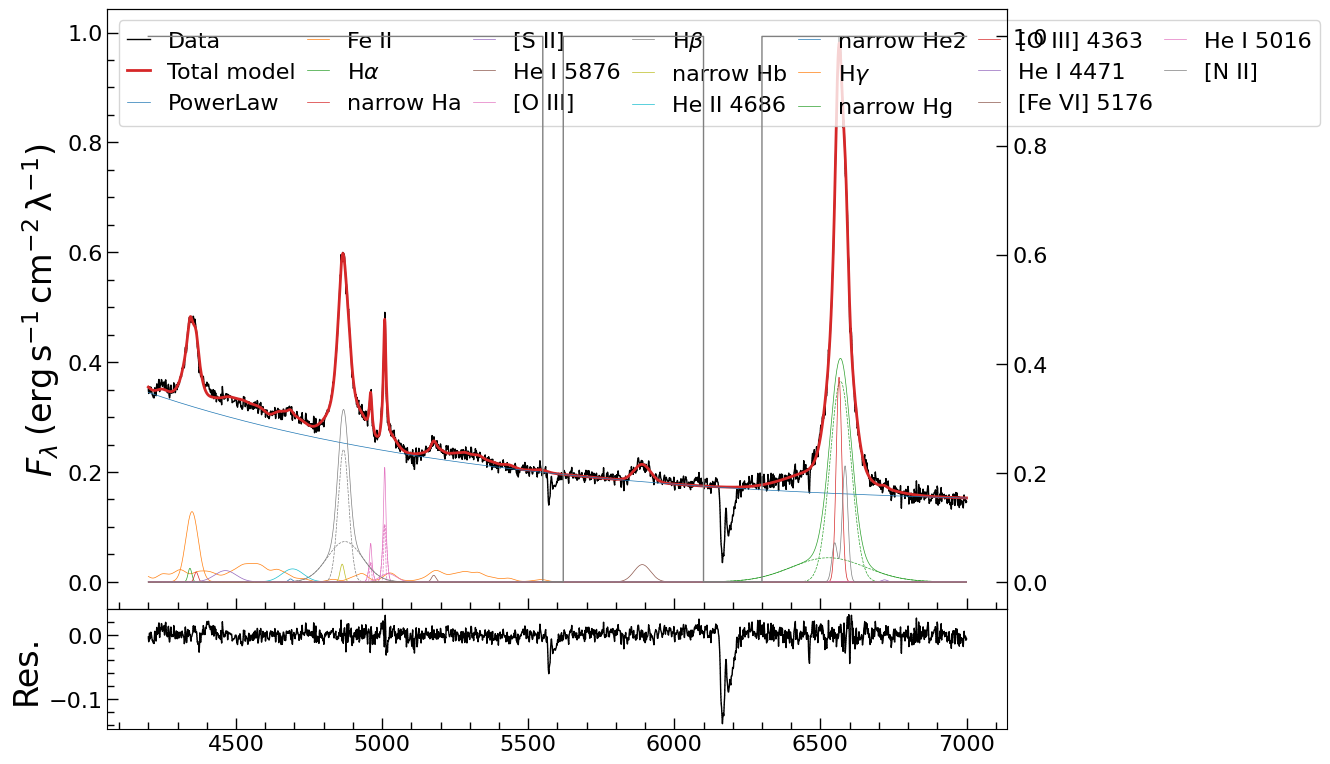

<PowerLaw1D(amplitude=0.23095267, x_0=5500., alpha=1.76748992, name='PowerLaw')>
<IronTemplate(amplitude=0.05133844, stddev=1274.34311919, z=0.00165071, name='Fe II')>
<Line_MultiGauss(amp_c=0.38392559, dv_c=267.87602671, sigma_c=1635.75363074, wavec=6562.819, amp_w0=0.12090744, dv_w0=-1961.32789799, sigma_w0=5817.37954601, name='H$\\alpha$')>
<Line_Gaussian(amplitude=0.39189974, dv=40.4546521, sigma=439.05339219, wavec=6562.819, name='narrow Ha')>
<Line_MultiGauss_doublet(amp_c0=0.00382946, amp_c1=0., dv_c=40.4546521, sigma_c=439.05339219, wavec0=6718.29, wavec1=6732.68, name='[S II]')>
<Line_MultiGauss(amp_c=0.03525822, dv_c=749.51807399, sigma_c=1449.88990461, wavec=5875.624, name='He I 5876')>
<Line_MultiGauss_doublet(amp_c0=0.11882764, amp_c1=0.03987505, dv_c=40.4546521, sigma_c=439.05339219, wavec0=5008.239, wavec1=4960.295, amp_w0=1., dv_w0=-6.64297204, sigma_w0=178.88059725, name='[O III]')>
<Line_MultiGauss(amp_c=0.27319536, dv_c=316.46774114, sigma_c=1117.7131749, wavec=4862.

In [30]:
wave_dict = sagan.utils.line_wave_dict
label_dict = sagan.utils.line_label_dict

poly = models.Polynomial1D(degree=2, name='multi') 
pl = models.PowerLaw1D(amplitude=0.23095267, x_0=5500, alpha=1.76748992, fixed={'x_0': True,'amplitude':True,'alpha':True},name='PowerLaw')
iron = sagan.IronTemplate(amplitude=0.05133844, stddev=1274.34311919, z=0, name='Fe II',fixed={'amplitude':True,'stddev':True})

bounds = {'sigma_w0': (100, 4000)}

b_ha = sagan.Line_MultiGauss(n_components=2, amp_c=0.57, dv_c=330, sigma_c=1050, 
                             wavec=wave_dict['Halpha'], name=label_dict['Halpha'],
                             amp_w0=0.24, dv_w0=-440, sigma_w0=3000)
b_hb = sagan.Line_MultiGauss(n_components=2, amp_c=0.3, dv_c=300, sigma_c=1400, 
                             wavec=wave_dict['Hbeta'], name=label_dict['Hbeta'],
                             amp_w0=0.47, dv_w0=250, sigma_w0=2900, bounds=bounds)
b_hg = sagan.Line_MultiGauss(n_components=1, amp_c=0.12, dv_c=500, sigma_c=1450, 
                             wavec=wave_dict['Hgamma'], name=label_dict['Hgamma'])

bounds = {'sigma_c': (100, 4000), 'dv_c': (-500, 500)}
b_he1 = sagan.Line_MultiGauss(n_components=1, amp_c=0.028, dv_c=660, sigma_c=1130, wavec=5875.624, name='He I 5876') 
line_s2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.01, amp_c1=0.011,
                                        wavec0=wave_dict['SII_6718'], wavec1=wave_dict['SII_6733'], name='[S II]')
#line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.19, amp_c1=0.066, dv_c=30, sigma_c=350, 
#                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
#                                        amp_w0=0.1, dv_w0=2000, sigma_w0=2500)
line_o3 = sagan.Line_MultiGauss_doublet(n_components=2, amp_c0=0.112, amp_c1=0.037, dv_c=20, sigma_c=204, 
                                        wavec0=wave_dict['OIII_5007'], wavec1=wave_dict['OIII_4959'], name='[O III]',
                                        amp_w0=1, dv_w0=60, sigma_w0=423)
b_he2 = sagan.Line_MultiGauss(n_components=1, amp_c=0.013, dv_c=500, sigma_c=3000, 
                              wavec=wave_dict['HeII_4686'], name=label_dict['HeII_4686'], 
                              bounds=bounds)
line_n2 = sagan.Line_MultiGauss_doublet(n_components=1, amp_c0=0.2, amp_c1=0.06, dv_c=30, sigma_c=200,
                                        wavec0=wave_dict['NII_6583'], wavec1=wave_dict['NII_6548'], name='[N II]')

n_ha = sagan.Line_Gaussian(amplitude=0.13, wavec=wave_dict['Halpha'], name=f'narrow Ha')
n_hb = sagan.Line_Gaussian(amplitude=0.05, wavec=wave_dict['Hbeta'], name=f'narrow Hb')
n_he2 = sagan.Line_Gaussian(amplitude=0.016, wavec=wave_dict['HeII_4686'], name=f'narrow He2')
n_hg = sagan.Line_Gaussian(amplitude=0.03, wavec=wave_dict['Hgamma'], name=f'narrow Hg')
n_o3_4363 = sagan.Line_Gaussian(amplitude=0.02, wavec=wave_dict['OIII_4363'], name=f'[O III] 4363')



n_fe6_5176 = sagan.Line_Gaussian(amplitude=0.02, wavec=wave_dict['FeVI_5176'], name=f'[Fe VI] 5176')
b_he1_5016 = sagan.Line_MultiGauss(n_components=1, amp_c=0.021, dv_c=300, sigma_c=1000,wavec=wave_dict['HeI_5016'], name='He I 5016')
b_he1_4471=sagan.Line_MultiGauss(n_components=1, amp_c=0.01, dv_c=-500, sigma_c=2000,wavec=wave_dict['HeI_4471'], name='He I 4471',bounds=bounds)

line_ha  =  b_ha + n_ha
line_he1 =  b_he1
line_hb  =  b_hb + n_hb
line_he2 =  b_he2 + n_he2
line_hg  =  b_hg + n_hg


m_init = (pl +iron+line_ha  + line_s2 +line_he1+line_o3+line_hb+line_he2+line_hg+ n_o3_4363+b_he1_4471+n_fe6_5176+b_he1_5016+line_n2)*poly
# line_ha  + line_s2 +line_he1+line_o3+line_hb+line_he2+line_hg+ n_o3_4363+b_he1_4471+n_fe6_5176+b_he1_5016

# Tie the line ratio of [O III] 5007/4959 to 2.98
def tie_o3(model):
    return model['[O III]'].amp_c0 / 2.98
line_o3.amp_c1.tied = tie_o3

def tie_n2(model):
    return model['[N II]'].amp_c0 / 2.96
line_n2.amp_c1.tied = tie_n2

# Tie
def tie_narrow_sigma(model):
    return model['[O III]'].sigma_c

def tie_narrow_dv(model):
    return model['[O III]'].dv_c

line_s2.sigma_c.tied = tie_narrow_sigma
line_s2.dv_c.tied = tie_narrow_dv
line_n2.sigma_c.tied = tie_narrow_sigma
line_n2.dv_c.tied = tie_narrow_dv

for line in [n_ha, n_hb, n_hg, n_he2, n_o3_4363,n_fe6_5176]:
    line.sigma.tied = tie_narrow_sigma
    line.dv.tied = tie_narrow_dv

fitter = fitting.LevMarLSQFitter()

weights = np.ones_like(flux_use)
fltr1 = (wave_use > 5550) & (wave_use < 5620)
fltr2 = (wave_use > 6100) & (wave_use < 6300)
fltr3 = (wave_use > 4200) & (wave_use < 4421)
#fltr4=(wave_use > 5029) & (wave_use < 5490)
fltr11=(wave_use > 4270) & (wave_use < 4430)
fltr12=(wave_use > 4600) & (wave_use < 5080)
fltr13=(wave_use > 5550) & (wave_use < 6050)
fltr14=(wave_use > 6200) & (wave_use < 6890)

weights[fltr1] = 0.0
weights[fltr2] = 0.0
#weights[fltr3] = 0.0
#weights[fltr4] = 0.0
#weights[fltr11] = 0.0
#weights[fltr12] = 0.0
#weights[fltr13] = 0.0
#weights[fltr14] = 0.0

m_fit = fitter(m_init, wave_use, flux_use, weights=weights, maxiter=10000)  # Important to set a large maxiter!

ax, axr = sagan.plot.plot_fit(wave_use, flux_use, m_fit, weight=weights)
ax.set_ylabel(r'$F_\lambda\:(\mathrm{erg\,s^{-1}\,cm^{-2}\,\lambda^{-1}})$', fontsize=24)
plt.show()

for m in m_fit:
    print(m.__repr__())